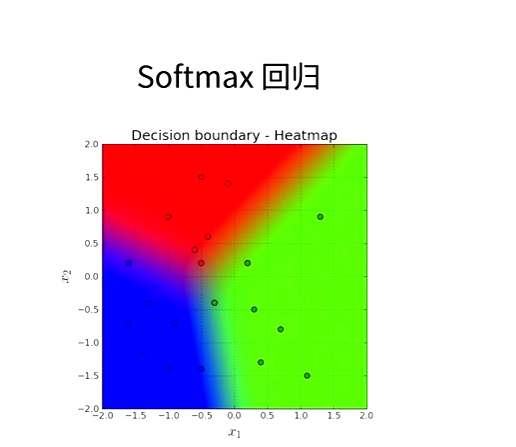
虽然是回归 但是实际是分类问题

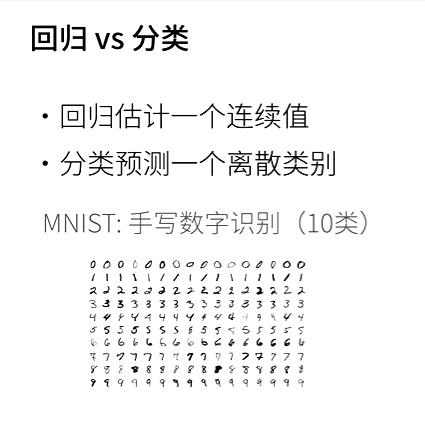

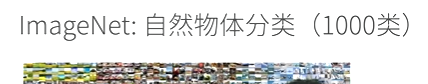

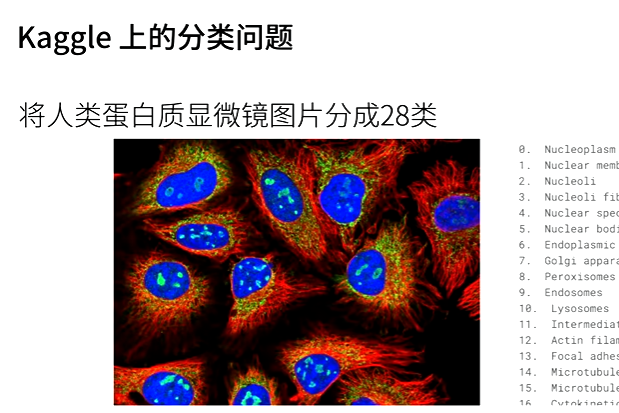

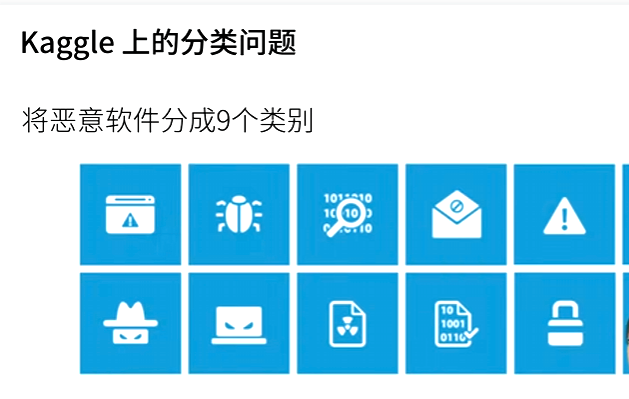

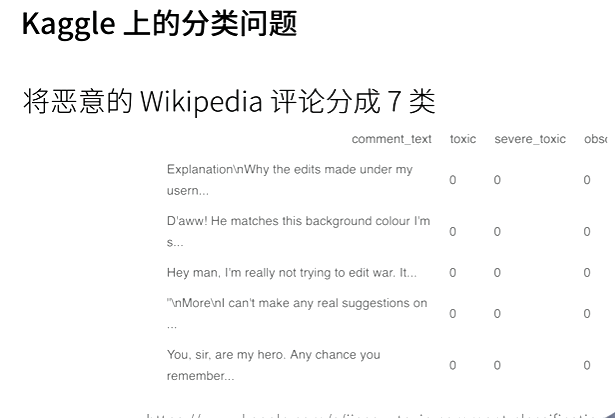

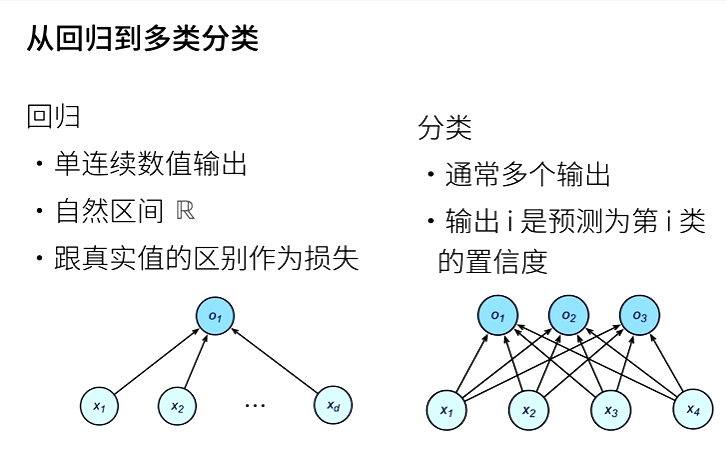

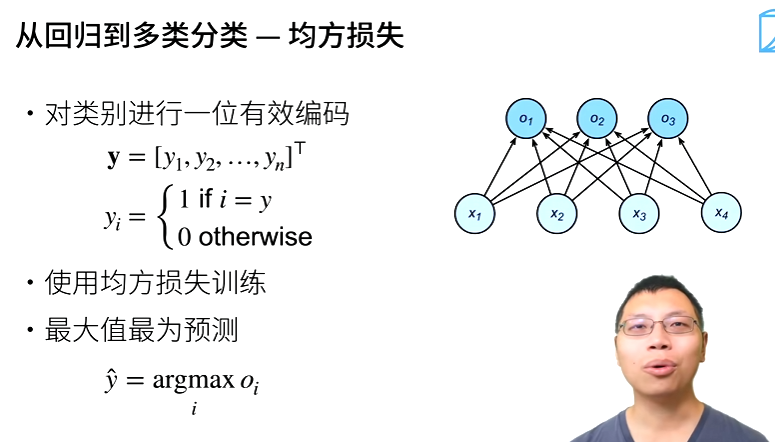

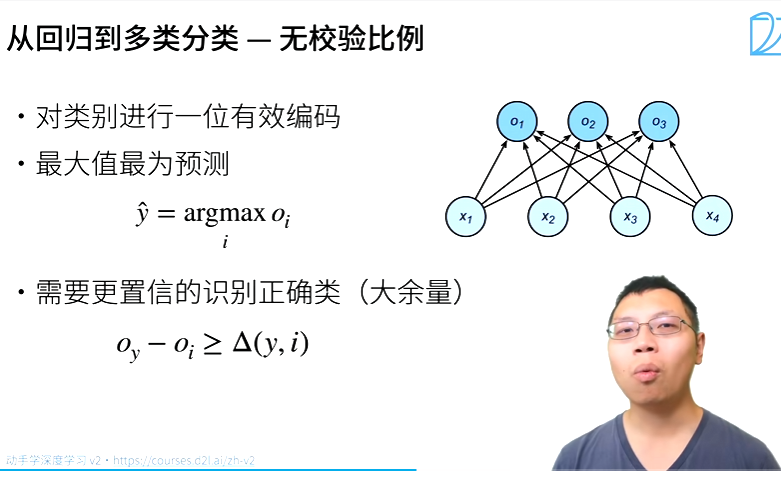

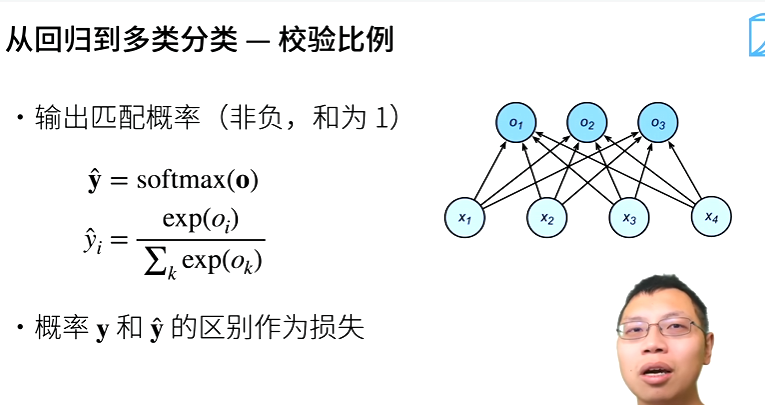

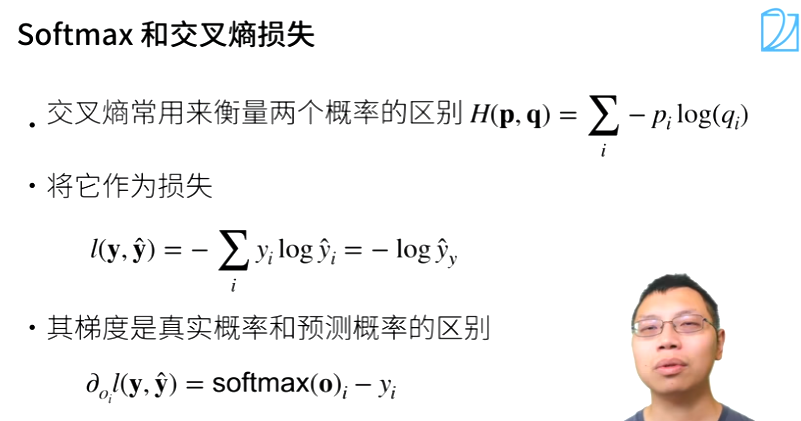

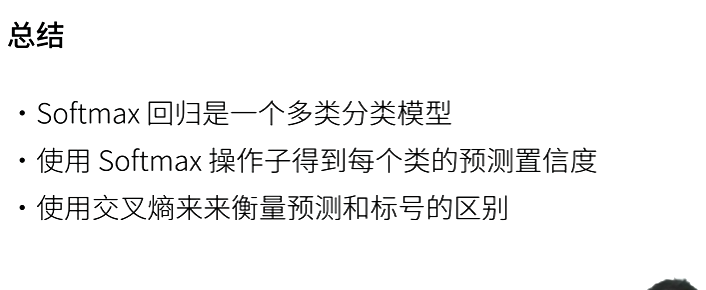

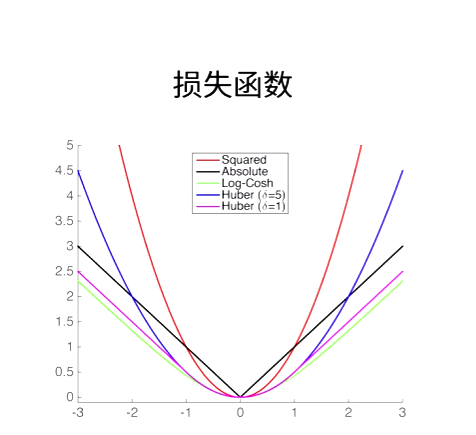

均方损失函数--线性回归中使用
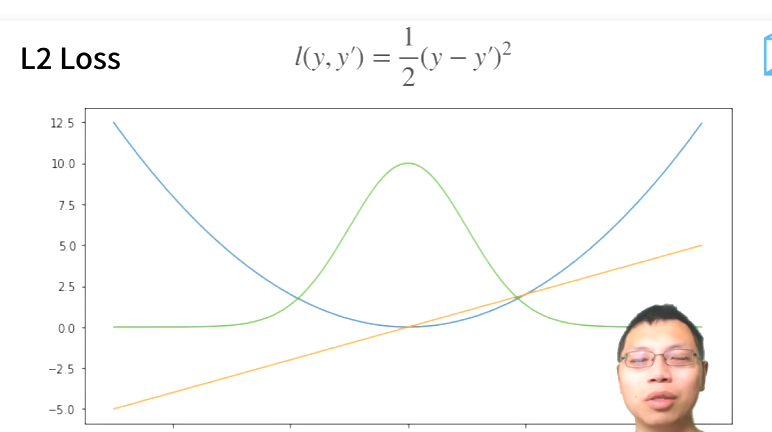
绝对值损失函数
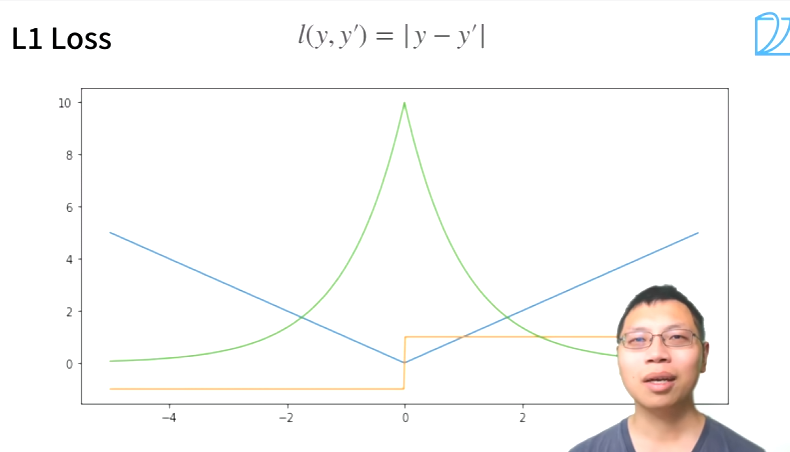
huber -- 上面两个的结合
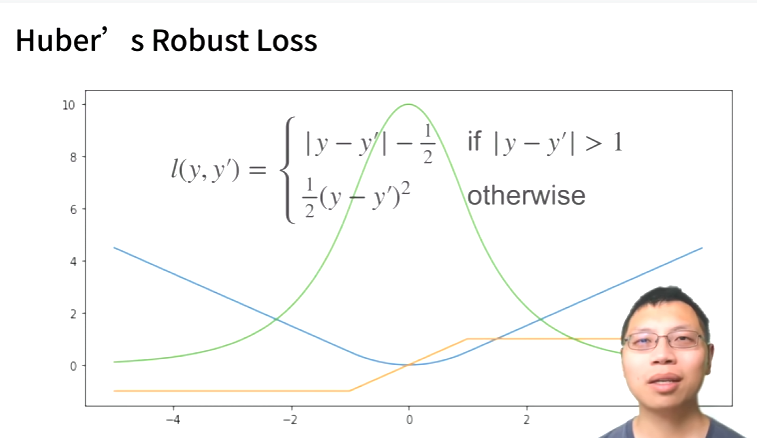

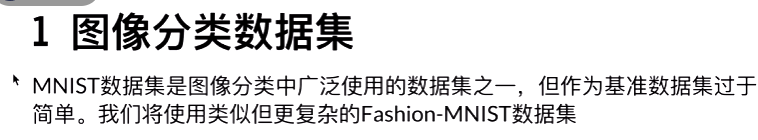

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
# Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 因此，训练集和测试集分别包含60000和10000张图像。 
# 测试数据集不会用于训练，只用于评估模型性能。

In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()#将图片转成pytorch的tensor
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [4]:
len(mnist_train), len(mnist_test)#6w条训练数据 3w条验证数据

(60000, 10000)

In [5]:
mnist_train[0][0].shape #图片的rgb为1 长和宽都是28

torch.Size([1, 28, 28])

In [6]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
# 我们现在可以创建一个函数来可视化这些样本 是关于衣服的数据集
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

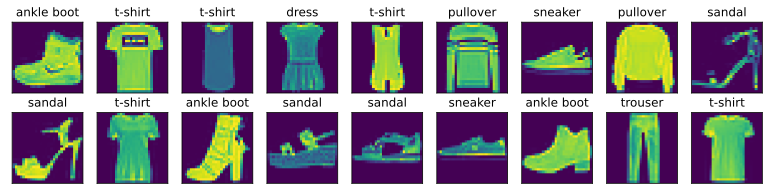

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [9]:
#读取小批量的数据 且大小为batch_size
# 在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。 
# 通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。

batch_size = 128

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=0)

In [10]:
#看一下读取的时间
timer = d2l.Timer() #测试读取速度
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.97 sec'

In [11]:
import torch
from torch.utils import data
from torchvision import transforms
import torchvision

def get_dataloader_workers():
    """返回4个进程用于数据加载"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    
    # 创建一个转换列表，首先将图像数据转换为Tensor
    trans = [transforms.ToTensor()]
    
    # 如果提供了resize参数，则在转换列表的最前面插入Resize操作
    if resize:
        trans.insert(0, transforms.Resize(resize))
    
    # 将转换列表组合成一个复合转换
    trans = transforms.Compose(trans)
    
    # 下载并加载训练集Fashion-MNIST数据，应用预处理变换
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    
    # 下载并加载测试集Fashion-MNIST数据，应用预处理变换
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    
    # 返回两个DataLoader实例，分别用于训练集和测试集
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

# 示例调用（此行可以删除或注释掉）
# train_loader, test_loader = load_data_fashion_mnist(batch_size=64, resize=(64, 64))


In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [13]:
#softmax回归的从0开始实现
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256 #随机读256个图片
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) #但会得到测试集和训练集

In [14]:
train_iter,test_iter

(<torch.utils.data.dataloader.DataLoader at 0x2601bbc3be0>,
 <torch.utils.data.dataloader.DataLoader at 0x2601dce5580>)

In [15]:
# 原始数据集中的每个样本都是28x28的图像
#  本节将展平每个图像，把它们看作长度为784的向量
#在softmax回归中，我们的输出与类别一样多。 因为我们的数据集有10个类别，
# 所以网络输出维度为10。
num_inputs = 784 #输入的我维度 28x28
num_outputs = 10 #输出的维度10

#初始化权重w 均值为0，方差为0.01 大小 行数为784 列数为10 true表示计算梯度
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)

#偏移b 偏移为一个长为10的向量
b = torch.zeros(num_outputs, requires_grad=True)

In [16]:
#定义softmax操作
# 例如可以对矩阵进行相加
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]) #定义一个2x3的矩阵
#分别按维度为0求和 即按行求和 
#或分别按维度为1求和 即按列求和
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

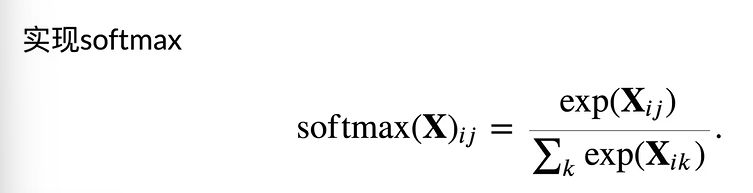

In [17]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [18]:
#随机创建一个均值为0 方差为1的 2行5列的矩阵
x = torch.normal(0,1,(2,5))
x

tensor([[-0.3903,  0.1884,  0.7304,  1.0777,  1.8799],
        [ 0.0113,  0.8914,  2.7531,  2.3623,  0.6422]])

In [19]:
x_prob = softmax(x) #形状不会发生变化 将负数变为正 且每一行和为1
x_prob,x_prob.sum(1) #按行来做加法

(tensor([[0.0503, 0.0898, 0.1543, 0.2184, 0.4872],
         [0.0319, 0.0770, 0.4957, 0.3353, 0.0600]]),
 tensor([1., 1.]))

In [20]:
#定义softmax回归模型
#用reshape函数将每张原始图像展平为向量
#orch.matmul是tensor的乘法，输入可以是高维的。
#函数y= w*x+b
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [21]:
#定义损失函数
#交叉熵采用真实标签的预测概率的负对数似然。
#例如 创建一个数据y_hat
#其中包含2个样本 在3个类别的预测值
y = torch.tensor([0, 2]) #创建一个长度为2的向量 第一个元素为0 第二个元素为2
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) #y_hat即预测值 一共3类
#第0个样本预测值 第1个样本的预测值
#0.1, 0.3, 0.6 =》0
#0.3, 0.2, 0.5 =》2
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [22]:
#实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y) #分别得到的是样本0的损失 和样本1的损失

tensor([2.3026, 0.6931])

In [23]:
#将预测类别与真实的y元素进行比较
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [24]:
# 第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。 
#第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。 
# 因此，这两个样本的分类精度率为0.5。

In [25]:
accuracy(y_hat, y) / len(y)

0.5

In [26]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [27]:
#我们在Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
evaluate_accuracy(net, test_iter)

0.1411

In [29]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [30]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [31]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

In [32]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

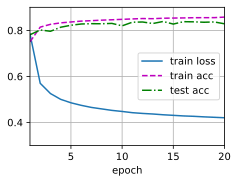

In [33]:
num_epochs = 20

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

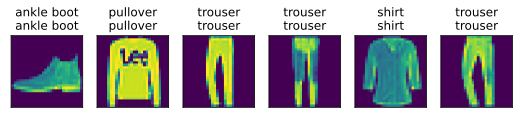

In [34]:
#从测试集中拿出一组数据 进行预测标签名
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [35]:
#softmax回归的简洁实现 通过深度学习框架的高级API能够实现softmax回归变得容易
import torch
from torch import nn #用pytorch的nn来实现模型
from d2l import torch as d2l

batch_size = 256
#先将数据拿到一个迭代器中
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_iter, test_iter

(<torch.utils.data.dataloader.DataLoader at 0x2601dd8b4f0>,
 <torch.utils.data.dataloader.DataLoader at 0x2601dd8bfa0>)

In [36]:
#softmax回归的输出层是一个全连接层
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状 连续的维度范围展平为张量

#nn.Linear(784, 10) 是一个线性层 输入是784维度 输出是10维度
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [37]:
def init_weights(m):
    # 定义一个初始化函数 init_weights，用于初始化神经网络层的权重
    if type(m) == nn.Linear:
        # 如果传入的层是一个线性层 (nn.Linear)
        nn.init.normal_(m.weight, std=0.01)
        # 则用正态分布（均值为0，标准差为0.01）来初始化该层的权重

# 将 init_weights 函数应用于整个网络的所有层
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [38]:
#定义损失函数为交叉熵函数 
#nn.CrossEntropyLoss() 是 PyTorch 提供的一个标准损失函数，
# 用于多分类任务。这个函数会将网络输出的 logits 和目标类别标签计算出一个交叉熵损失，
# 常用于分类问题。
loss = nn.CrossEntropyLoss()

In [39]:
# 定义优化器为随机梯度下降（SGD），学习率为0.1
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
# net.parameters() 指定了需要优化的参数（即神经网络的参数），
# lr=0.1 指定了学习率为0.1。

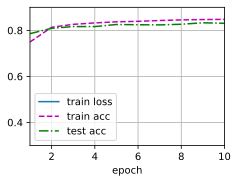

In [40]:
# 定义训练的轮数为10
num_epochs = 10

# 使用d2l定义的train_ch3函数训练模型
# 参数依次为：神经网络net，训练数据迭代器train_iter，测试数据迭代器test_iter，
# 损失函数loss，训练轮数num_epochs，优化器trainer
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)